# MiniProject - Variant 3 - Group M

## Imports

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

import sklearn
import time
# import mat73 # requires pip install mat73

from align import align

from sklearn.decomposition import PCA, FastICA, NMF

from tqdm.notebook import tqdm

## Loading data
Only three subjects are downloaded

<span style="color:orange">**You need to download the data if you haven't already. Otherwise, leave these two cells commented out.**</span>

In [24]:
# !pip install gdown

In [25]:
# import gdown

# url = "https://drive.google.com/uc?id=1fhX5gCvmqkFrQ_Um9WXzYdmDUCXadzrJ"
# output = "sub/s1.mat"
# gdown.download(url, output, quiet = False)

# url = "https://drive.google.com/uc?id=1fhc-JCSnzE_oDOMszP9FsgmpxFUFAwYP"
# output = "sub/s2.mat"
# gdown.download(url, output, quiet = False)

# url = "https://drive.google.com/uc?id=1yWCwEKDaa97ZD44t1tS8i1IOJ5GIbROp"
# output = "sub/s3.mat"
# gdown.download(url, output, quiet = False)

In [26]:
n_subject = 3   

sub_files = []
for i in range(1, n_subject+1):
    sub_files.append(loadmat('sub/s' + str(i) + '.mat'))
    print("The type of the file nb " + str(i) + " is: " + str(type(sub_files[i-1])))
    print("The keys of the file nb " + str(i) + " are: " + str(sub_files[i-1].keys()))
    print("\n\n")

The type of the file nb 1 is: <class 'dict'>
The keys of the file nb 1 are: dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])



The type of the file nb 2 is: <class 'dict'>
The keys of the file nb 2 are: dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])



The type of the file nb 3 is: <class 'dict'>
The keys of the file nb 3 are: dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])





In [27]:
print("number of uniques in adjusted_class_new:         " + str(len(np.unique(sub_files[0]["adjusted_class_new"]))))
print("number of uniques in adjusted_repetition_new:    " + str(len(np.unique(sub_files[0]["adjusted_repetition_new"]))))
print("Shape of emg_flexors_new:                        " + str(sub_files[0]['emg_flexors_new'].shape))

number of uniques in adjusted_class_new:         31
number of uniques in adjusted_repetition_new:    6
Shape of emg_flexors_new:                        (3000000, 8, 8)


## Part 1

### Preprocessing the data


<font color='aqua'>Compute the **spatial** synergies using different blind source separation algorithms
(e.g. PCA, ICA, NMF). Are the synergies stable?</font>

In this reduced data, we have `Fs`, `adjusted_class_new`, `adjusted_repetition_new`, `emg_flexors_new`. In `emg_flexors_new`, we have the data from the sensor's data from the EMG.

This function is here to preprocess the data. When call it will return the envelope of the signal

In [28]:
def preprocess_data(sub, sub_files, last_value=1000000, peak_value=2):
    
    emg = sub_files[sub]['emg_flexors_new'].copy()
       
    emg[emg > peak_value] = peak_value
    emg[emg < -peak_value] = -peak_value
    
    n_channels = emg.shape[1]*emg.shape[2]

    emg = emg.reshape(emg.shape[0], n_channels)

    emg_subsampled = emg[::2, :] # subsample by steps of 2 to reduce data size for easier computation
    emg_rectified = emg_subsampled ** 2 # rectify the signal.

    weights = np.ones(200) / 200        
    emg_envelope_200 = convolve1d(emg_rectified, weights=weights, axis=0)
    
    emg_envelope_200 = emg_envelope_200[:last_value]
    return emg_envelope_200

In [29]:
emg_flexors_envelope_200 = preprocess_data(sub=0, sub_files=sub_files)

### Visualizing the data

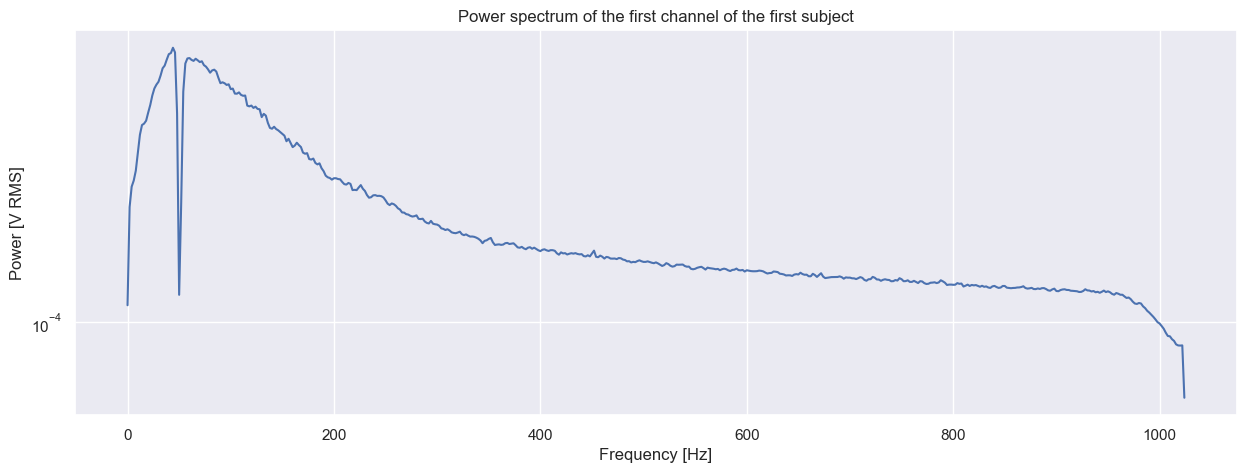

In [30]:
freq_pre, power_pre = welch(sub_files[0]["emg_flexors_new"][:,0,0], fs=sub_files[0]['Fs'][0,0], nperseg=1024)

# Plot them

plt.figure(figsize=(15,5))

plt.semilogy(freq_pre, np.sqrt(power_pre))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [V RMS]")
plt.title("Power spectrum of the first channel of the first subject")

plt.show()

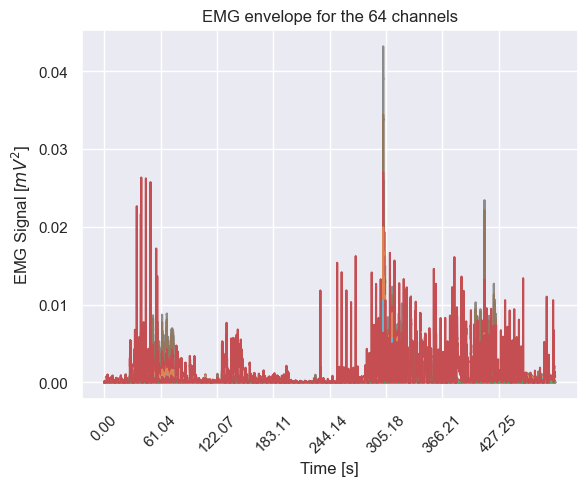

In [31]:
plt.xticks(np.arange(0, len(emg_flexors_envelope_200), len(emg_flexors_envelope_200) / 8), ['%.2f' % x for x in np.arange(0, len(emg_flexors_envelope_200)/sub_files[0]['Fs'][0,0], len(emg_flexors_envelope_200) / 8 / sub_files[0]['Fs'][0,0])], rotation=45)
plt.title('EMG envelope for the 64 channels')
plt.plot(emg_flexors_envelope_200)
plt.xlabel('Time [s]')
plt.ylabel(f'EMG Signal [$mV^2$]')
plt.show()

In [32]:
def plot_synergies(envelope, H, W, fs=sub_files[0]['Fs'][0,0], title=None):
    
    # Plot synthetic EMG data
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(envelope)
    plt.xticks(np.arange(0, len(envelope), len(envelope) / 8), ['%.2f' % x for x in np.arange(0, len(envelope)/fs, len(envelope) / 8 / fs)], rotation=45)
    plt.title('EMG envelope')
    plt.xlabel('Time [s]')
    plt.ylabel(f'EMG Signal [$mV^2$]')

    # Plot extracted synergies
    plt.subplot(3, 1, 2)
    plt.plot(H.T)
    plt.title('Extracted Muscle Synergies')
    plt.xlabel('Channels')
    plt.ylabel('Synergy Value')

    # Plot extracted activation coefficients
    plt.subplot(3, 1, 3)
    plt.plot(W)
    plt.xticks(np.arange(0, len(W), len(W) / 8), ['%.2f' % x for x in np.arange(0, len(W)/fs, len(W) / 8 / fs)], rotation=45)
    plt.title('Extracted Activation Coefficients')
    plt.xlabel('Time [s]')
    plt.ylabel('Activation Level [a.u.]')
    
    if title is not None:
        plt.suptitle(title)

    plt.tight_layout()

## Part 2



<font color='aqua'>*Compute the spatial synergies using different blind source separation algorithms
(e.g. PCA, ICA, NMF). Are the synergies stable?*</font>

### Spatial synergies using BSS

Here, we compute the NMF, PCA and ICA separately, and then plot the results, for a whole subject.

### NMF

This first cell computes the NMF for the different number of components, and we plot the r2 score to determine the best value

In [33]:
r_2_nmf = np.zeros(6)
for syn in [1,2,3,4,5,6]:
    nmf = NMF(n_components=syn, init="nndsvda", max_iter=1000)
    nmf.fit(emg_flexors_envelope_200)
    # Use nmf.fit_transform (W) and nmf.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
    W_nmf = nmf.transform(emg_flexors_envelope_200)
    H_nmf = nmf.components_
    channel_envelope_pred = np.dot(W_nmf, H_nmf)
    r_2_nmf[syn-1] = sklearn.metrics.r2_score(emg_flexors_envelope_200, channel_envelope_pred)
    print("r2 score for " + str(syn) + " synergies is: " + str(r_2_nmf[syn-1]))

c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


r2 score for 1 synergies is: -0.006161366410881219
r2 score for 2 synergies is: 0.13580784655435144
r2 score for 3 synergies is: 0.3147803103865954
r2 score for 4 synergies is: 0.43901215052488474
r2 score for 5 synergies is: 0.5067211539440382


c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


r2 score for 6 synergies is: 0.5283382615017534


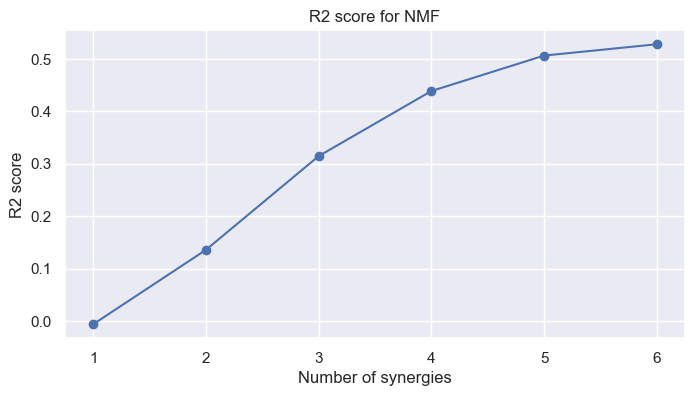

In [34]:
plt.figure(figsize=(8, 4))
plt.plot(r_2_nmf, 'o-')
plt.title('R2 score for NMF')
plt.xlabel('Number of synergies')
plt.ylabel('R2 score')
plt.xticks(np.arange(6), np.arange(1,7))
plt.show()

We now use the value we determined to be the best, and compute the NMF with it.

In [35]:
# For now let's just use 5 components. Parameters: init="nndsvda", max_iter=500.
nmf = NMF(n_components=5, init="nndsvda", max_iter=500)

t = time.time()
nmf.fit(emg_flexors_envelope_200)
print("Elapsed time: ", time.time() - t)

# Use nmf.fit_transform (W) and nmf.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
W_nmf = nmf.transform(emg_flexors_envelope_200)
H_nmf = nmf.components_

Elapsed time:  51.70576882362366


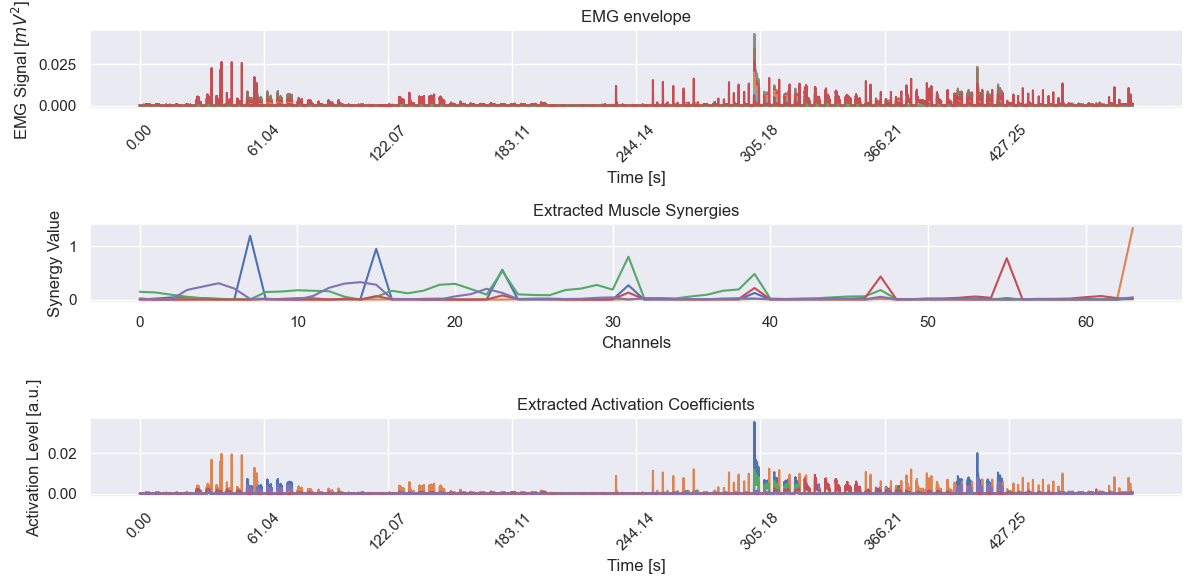

In [36]:
plot_synergies(emg_flexors_envelope_200, H_nmf, W_nmf)

### PCA

We repeat the same process as with the NMF. We compute the r score for different number of components, and plot the r2 score. However, here, we need to center the data first.

In [37]:
means_channel = np.mean(emg_flexors_envelope_200, axis=0)
centered_emg = emg_flexors_envelope_200 - np.ones(emg_flexors_envelope_200.shape) * means_channel

print("Mean of means of channels: ", np.mean(np.mean(emg_flexors_envelope_200, axis=0)))

Mean of means of channels:  8.28237891937753e-05


In [38]:
r_2_pca = np.zeros(6)
for syn in [1,2,3,4,5,6]:
    pca = PCA(n_components=syn)
    # Use nmf.fit_transform (W) and nmf.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
    W_pca = pca.fit_transform(centered_emg)
    H_pca = pca.components_
    channel_envelope_pred = np.dot(W_pca, H_pca)
    r_2_pca[syn-1] = sklearn.metrics.r2_score(centered_emg, channel_envelope_pred)
    print("r2 score for " + str(syn) + " synergies is: " + str(r_2_pca[syn-1]))

r2 score for 1 synergies is: 0.5405090170974232
r2 score for 2 synergies is: 0.5935130429282325
r2 score for 3 synergies is: 0.7711836713519149
r2 score for 4 synergies is: 0.8535404646066076
r2 score for 5 synergies is: 0.8780964542924639
r2 score for 6 synergies is: 0.885375714402539


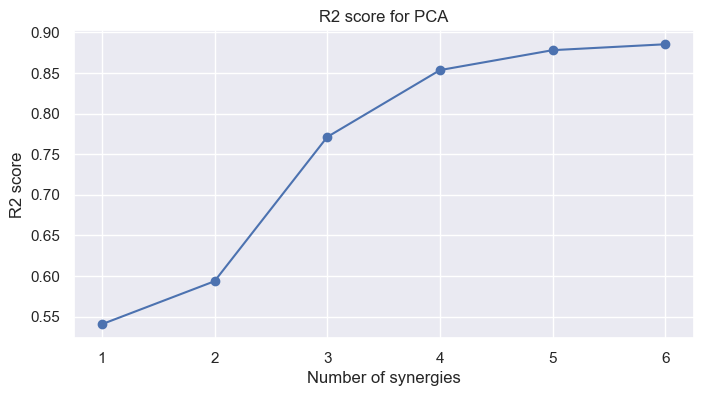

In [39]:
plt.figure(figsize=(8, 4))
plt.plot(r_2_pca, 'o-')
plt.title('R2 score for PCA')
plt.xlabel('Number of synergies')
plt.ylabel('R2 score')
plt.xticks(np.arange(6), np.arange(1,7))
plt.show()

And again, we plot the the final results for the PCA using this number of components value.

In [40]:
pca = PCA(n_components=5)

W_pca = pca.fit_transform(centered_emg)
H_pca = pca.components_

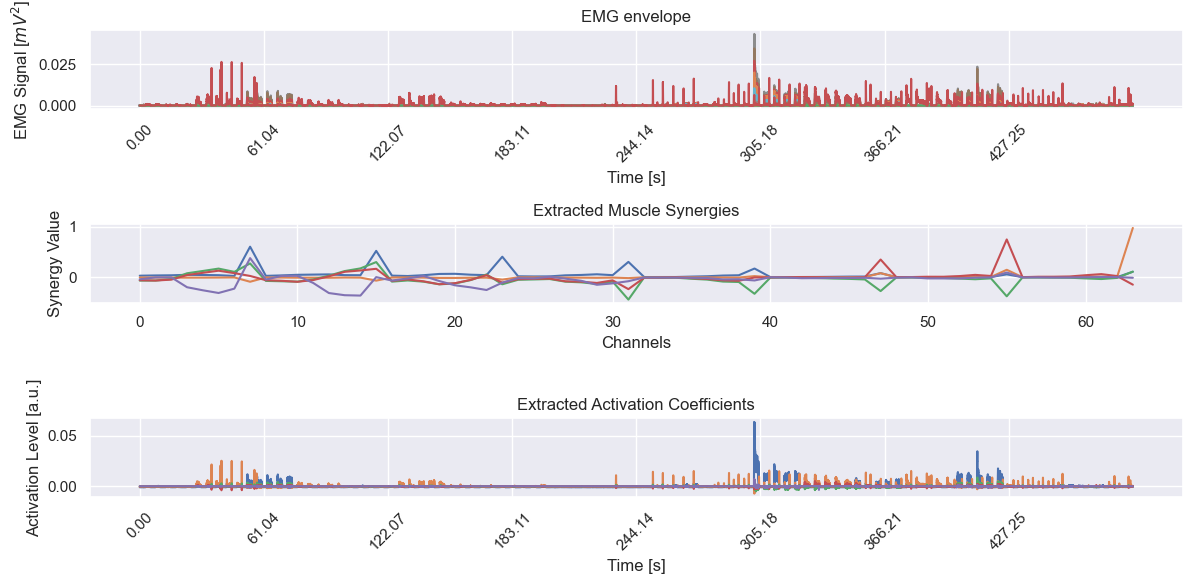

In [41]:
plot_synergies(emg_flexors_envelope_200, H_pca, W_pca) 

### ICA

And finally, we do the same for the ICA as the PCA, using the centered data.

In [42]:
r_2_ica = np.zeros(6)
for syn in [1,2,3,4,5,6]:
    ica = FastICA(n_components=syn)
    ica.fit(centered_emg)
    # Use nmf.fit_transform (W) and nmf.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
    W_ica = ica.transform(centered_emg)
    H_ica = ica.mixing_.T
    channel_envelope_pred_ica = W_ica @ H_ica
    r_2_ica[syn-1] = sklearn.metrics.r2_score(centered_emg, channel_envelope_pred_ica)
    print("r2 score for " + str(syn) + " synergies is: " + str(r_2_ica[syn-1]))

r2 score for 1 synergies is: 0.5405090170974256
r2 score for 2 synergies is: 0.5935130429282335
r2 score for 3 synergies is: 0.771183671351915
r2 score for 4 synergies is: 0.853540464606608
r2 score for 5 synergies is: 0.8780964542924634
r2 score for 6 synergies is: 0.8853757144025529


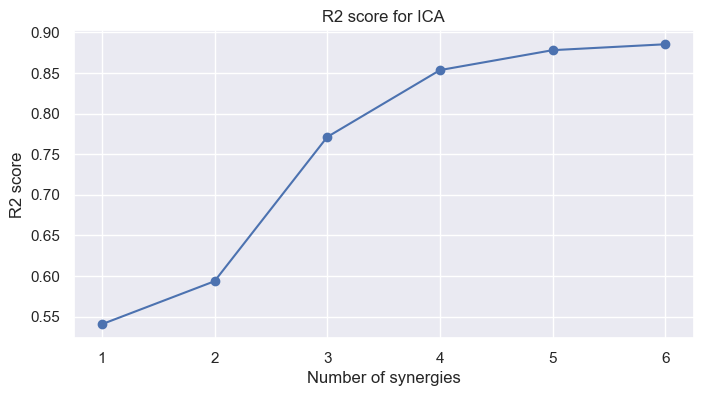

In [43]:
plt.figure(figsize=(8, 4))
plt.plot(r_2_ica, 'o-')
plt.title('R2 score for ICA')
plt.xlabel('Number of synergies')
plt.ylabel('R2 score')
plt.xticks(np.arange(6), np.arange(1,7))
plt.show()

In [44]:
ica = FastICA(n_components=5)
# Use ica.transform (W) and ica.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
W_ica = ica.fit_transform(centered_emg)
H_ica = ica.mixing_.T

Text(0.5, 1.0, 'First channel')

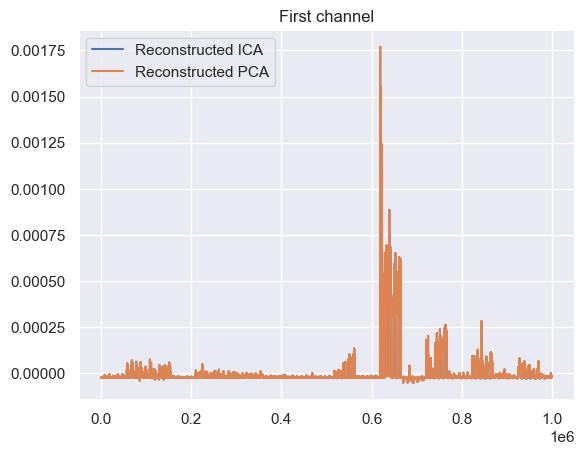

In [45]:
reconstructed_pca = W_pca @ H_pca
reconstructed_ica = W_ica @ H_ica

plt.plot(reconstructed_ica[:, 0], label="Reconstructed ICA")
plt.plot(reconstructed_pca[:, 0], label="Reconstructed PCA")
# plt.plot(centered_emg[:, 0], label="Original")
plt.legend()
plt.title("First channel")

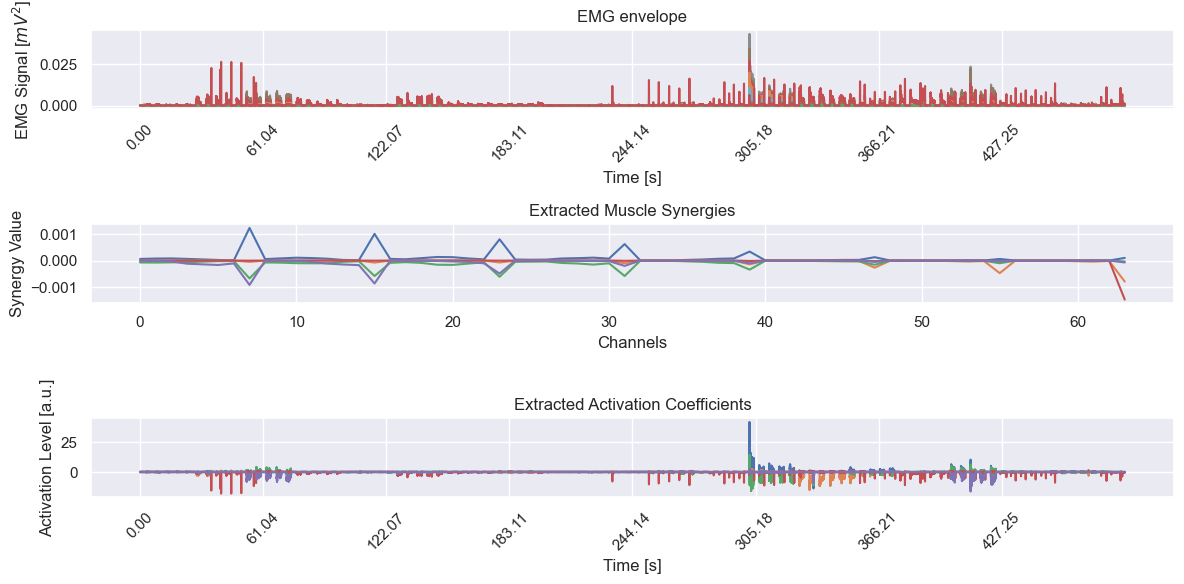

In [46]:
# Plot synthetic EMG data
plot_synergies(emg_flexors_envelope_200, H_ica, W_ica)

Run this cell to compare the results between the 3 methods, by plotting the synergies

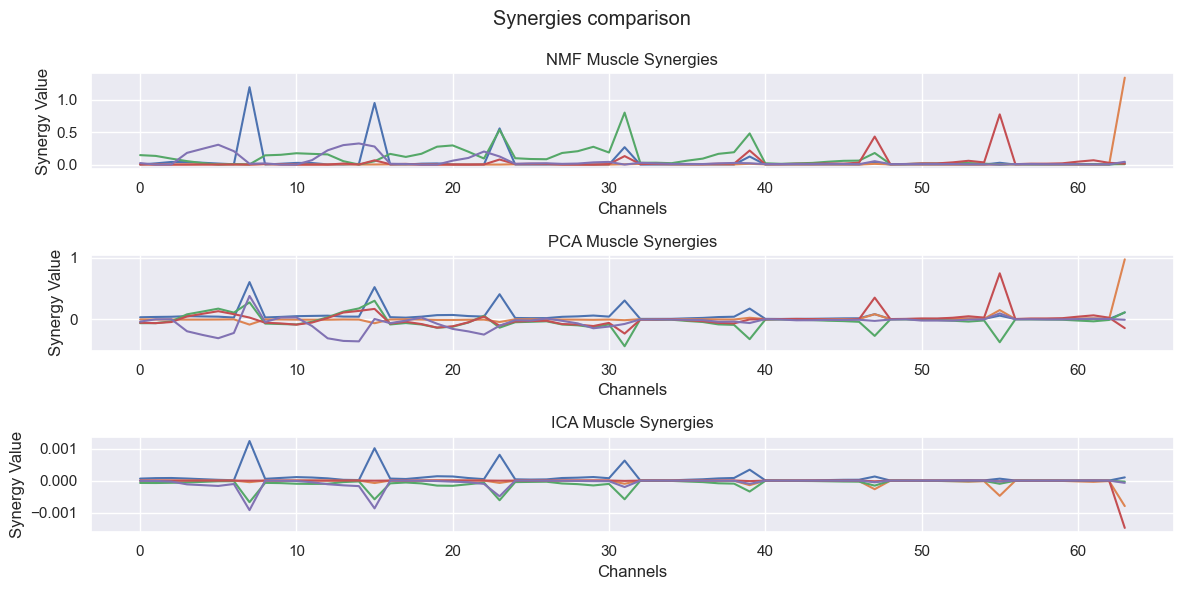

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(H_nmf.T)
plt.title('NMF Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

plt.subplot(3, 1, 2)
plt.plot(H_pca.T)
plt.title('PCA Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

plt.subplot(3, 1, 3)
plt.plot(H_ica.T)
plt.title('ICA Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

plt.suptitle("Synergies comparison")
plt.tight_layout()
plt.show()

## Part 3




<font color='aqua'>*Compute the spatial synergies corresponding to different subsets of the data
samples. Are the synergies stable across the different subsets?*</font>

### Comparaison


We want to divide the dataset into multiple subsets, and analyse each one of them. This is what this cell does. It will store the different H and W matrices in the lists `H_sub` and `W_sub` respectively. For now, we are only doing it with the _NMF_. Be careful, if you want to run this cell for _ICA_, you will need to change the code for it to use `model.mixing_.T` instead of `model.components_`. And for both the _ICA_ and the _PCA_, you'll need to use the centered data instead.

In [48]:
n_subsets: int = 10

model = NMF(n_components=5, init="nndsvda", max_iter=500)
    
W_sub: list = []
H_sub: list = []
interval: int = int(emg_flexors_envelope_200.shape[0]/n_subsets)

for i in range(n_subsets):
    model.fit(emg_flexors_envelope_200[i*interval:(i+1)*interval])
    
    W_sub.append(model.transform(emg_flexors_envelope_200[i*interval:(i+1)*interval]))
    H_sub.append(model.components_)

c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.w

[[3.56361660e-05 5.70668952e-05 8.97116177e-04 6.04317066e-05
  0.00000000e+00]
 [3.56981234e-05 5.62237241e-05 8.99004793e-04 6.05421280e-05
  0.00000000e+00]
 [3.53095316e-05 5.69051697e-05 8.98839141e-04 6.02790376e-05
  0.00000000e+00]
 ...
 [1.61409265e-03 1.08884902e-03 5.76454450e-04 1.30370458e-03
  6.74065311e-04]
 [1.61082595e-03 1.08300790e-03 5.80323602e-04 1.30596156e-03
  6.59331898e-04]
 [1.60969191e-03 1.01140304e-03 5.86429163e-04 1.31767801e-03
  6.03670661e-04]]


TypeError: unsupported operand type(s) for /: 'int' and 'str'

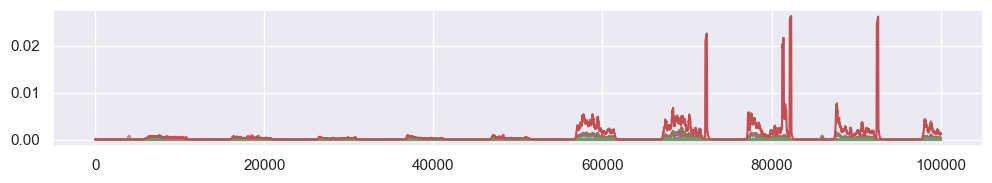

In [61]:
for i in range(n_subsets):
    plot_synergies(emg_flexors_envelope_200[i*interval:(i+1)*interval], H_sub[i], W_sub[i], "Subset nb {}".format(i+1))

In [ ]:
fig, ax = plt.subplots(n_subsets, 1, figsize=(12, 2*n_subsets))

for i in range(n_subsets):
    ax[i].plot(H_sub[i].T)
    ax[i].set_title("Subset nb {}".format(i+1))
    ax[i].set_xlabel("Channels")
    ax[i].set_ylabel("Synergy Value")
    
plt.tight_layout()
plt.show()

## Part 4


*<span style="color:aqua">Compute the spatial synergies for different subjects. Is it now stable across the
different subjects? </span>*

Now, we want to compare the data between different subjects. 

In [ ]:

# Plot the three datas for each patient
fig, ax = plt.subplots(3, 1, figsize=(12, 6))

tmp_emg = sub_files[0]["emg_flexors_new"]
tmp_emg[tmp_emg > 2] = 2
tmp_emg[tmp_emg < -2] = -2
ax[0].plot(np.reshape((tmp_emg), (sub_files[0]["emg_flexors_new"].shape[0], 64)))
ax[0].set_title("Subject 1")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel(f"Envelope [$mV^2$]")
ax[0].set_xticks(np.arange(0, len(sub_files[0]["emg_flexors_new"]), len(sub_files[0]["emg_flexors_new"]) / 8))
ax[0].set_xticklabels(['%.2f' % x for x in np.arange(0, len(sub_files[0]["emg_flexors_new"])/sub_files[0]['Fs'][0,0], len(sub_files[0]["emg_flexors_new"]) / 8 / sub_files[0]['Fs'][0,0])], rotation=45)

tmp_emg = sub_files[1]["emg_flexors_new"]
tmp_emg[tmp_emg > 2] = 2
tmp_emg[tmp_emg < -2] = -2
ax[1].plot(np.reshape((tmp_emg), (sub_files[1]["emg_flexors_new"].shape[0], 64)))
ax[1].set_title("Subject 2")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel(f"Envelope [$mV^2$]")
ax[1].set_xticks(np.arange(0, len(sub_files[1]["emg_flexors_new"]), len(sub_files[1]["emg_flexors_new"]) / 8))
ax[1].set_xticklabels(['%.2f' % x for x in np.arange(0, len(sub_files[1]["emg_flexors_new"])/sub_files[1]['Fs'][0,0], len(sub_files[1]["emg_flexors_new"]) / 8 / sub_files[1]['Fs'][0,0])], rotation=45)

tmp_emg = sub_files[2]["emg_flexors_new"]
tmp_emg[tmp_emg > 2] = 2
tmp_emg[tmp_emg < -2] = -2
ax[2].plot(np.reshape((tmp_emg), (sub_files[2]["emg_flexors_new"].shape[0], 64)))
ax[2].set_title("Subject 3")
ax[2].set_xlabel("Time [s]")
ax[2].set_ylabel(f"Envelope [$mV^2$]")
ax[2].set_xticks(np.arange(0, len(sub_files[2]["emg_flexors_new"]), len(sub_files[2]["emg_flexors_new"]) / 8))
ax[2].set_xticklabels(['%.2f' % x for x in np.arange(0, len(sub_files[2]["emg_flexors_new"])/sub_files[2]['Fs'][0,0], len(sub_files[2]["emg_flexors_new"]) / 8 / sub_files[2]['Fs'][0,0])], rotation=45)

plt.tight_layout()
plt.show()

del tmp_emg

Again, this is the code for the _NMF_. If you want to use the _ICA_ or the _PCA_, you'll need to bring the same changes as in **Part 3**

In [ ]:
n_subject: int = 3
 
W_subject: list = []
H_subject: list = []
envelope_subject: list = []

for i in range(n_subject):

    emg_envelope = preprocess_data(sub=i, sub_files=sub_files)
    envelope_subject.append(emg_envelope)
    
    model = NMF(n_components=5, init="nndsvda", max_iter=500)
    model.fit(emg_envelope)
    
    W_subject.append(model.transform(emg_envelope))
    H_subject.append(model.components_)

In [ ]:
range_plot = 100000
start = 0

for i in range(n_subject):
    plot_synergies(envelope_subject[i][start:start+range_plot], H_subject[i], W_subject[i][start:start+range_plot], "Subject nb {}".format(i+1))

Here, we plot the synergies accross the different subjects.

In [ ]:
fig, ax = plt.subplots(n_subject, 1, figsize=(12, 2*n_subject))

for i in range(n_subject):
    ax[i].plot(H_subject[i].T)
    ax[i].set_title("Subject nb {}".format(i+1))
    ax[i].set_xlabel("Channels")
    ax[i].set_ylabel("Synergy Value")

plt.tight_layout()
plt.show()

## Part 5

*<span style="color:aqua">Try to vary the frequencies used in the preprocessing step. Compute the spatial
synergies again. Does the choice of filtering frequencies affects the stability of the
synergies?</span>*

We need to modify the `preprocess_data` function. But instead of this, and in order to keep the whole code working, we created a modified one named `preprocess_data_part5`. The difference here is we apply a butterworth filter to the data, in order to change the frequencies of choice.

In [ ]:
def preprocess_data_part5(sub, sub_files, last_value=1200000, peak_value=2, Wn=(), N=4):
    Fs = sub_files[sub]['Fs'][0,0].copy()
    emg = sub_files[sub]['emg_flexors_new'].copy()
       
    emg[emg > peak_value] = peak_value
    emg[emg < -peak_value] = -peak_value
    
    n_channels = emg.shape[1]*emg.shape[2]

    emg = emg.reshape(emg.shape[0], n_channels)
    
    sos = butter(N=N, fs=Fs, Wn=Wn, btype="bandpass", output="sos")
    emg_filtered = sosfiltfilt(sos, emg.T).T
    
    # Easier method to compute the envelope 

    emg_subsampled = emg_filtered[::2, :] # subsample by steps of 2 to reduce data size for easier computation
    emg_rectified = emg_subsampled ** 2 # rectify the signal. We could also use abs

    weights = np.ones(200) / 200        
    emg_envelope_200 = convolve1d(emg_rectified, weights=weights, axis=0)
    
    emg_envelope_200 = emg_envelope_200[:last_value]
    return emg_envelope_200

Here, you can choose the _BSS_ methods you want to use for the code. This will do the same as before, but use different sets of frequencies for the filter.

In [ ]:
frequencies = [(5, 167), (167, 333), (333, 500)]
sub_n = 0
BSS = "NMF"

W_freq: list = []
H_freq: list = []
envelope_freq: list = []

for frequency in frequencies:

    emg_envelope = preprocess_data_part5(sub=sub_n, sub_files=sub_files, Wn=frequency, N=4)
    
    if BSS == "NMF":
        model = NMF(n_components=5, init="nndsvda", max_iter=500)
        envelope_freq.append(emg_envelope)
        
    else:
        means_channel = np.mean(emg_envelope, axis=0)
        centered_emg = emg_envelope - np.ones(emg_envelope.shape) * means_channel

        if BSS == "PCA":
            model = PCA(n_components=5) 
        elif BSS == "ICA":
            model = FastICA(n_components=5)
            
        envelope_freq.append(centered_emg)
    
    W_freq.append(model.fit_transform(envelope_freq[-1]))
    
    if BSS == "ICA":
        H_freq.append(model.mixing_.T)
    else:
        H_freq.append(model.components_)

In [ ]:
fig, ax = plt.subplots(len(frequencies), 1, figsize=(12, 2*len(frequencies)))

for i in range(len(frequencies)):
    ax[i].plot(H_freq[i].T)
    ax[i].set_title("Frequencies kept {} [Hz]".format(frequencies[i]))
    ax[i].set_xlabel("Channels")
    ax[i].set_ylabel("Synergy Value")
    
plt.tight_layout()
plt.show()

## Part 6



*<span style="color:aqua">Evaluate the stability of the synergies across the different BSS algorithms with
respect to the tasks 3-4-5. Which algorithm performs better, and which one is least
stable. Discuss the pros and cons of the different algorithms.</span>*

In [ ]:
def mse(W, H, emg):
    reconstructed = W @ H
    mse = np.mean((emg - reconstructed) ** 2)
    return mse

Rerun the following cell in case you want to only run **part 6**.

In [ ]:
emg_flexors_envelope_200 = preprocess_data(sub=0, sub_files=sub_files)

In [ ]:
n_subsets: int = 10
interval: int = int(emg_flexors_envelope_200.shape[0]/n_subsets)
methods = ["NMF", "PCA", "ICA"]

W_sub = np.zeros((n_subsets, 3, interval, 5))
H_sub = np.zeros((n_subsets, 3, 5, 64))
mse_sub = np.zeros((n_subsets, 3))

means_channel = np.mean(emg_flexors_envelope_200, axis=0)
centered_emg = emg_flexors_envelope_200 - np.ones(emg_flexors_envelope_200.shape) * means_channel

for index, BSS in enumerate(methods):
    if BSS == "NMF":
        model = NMF(n_components=5, init="nndsvda", max_iter=500)
        for i in range(n_subsets):
            model.fit(emg_flexors_envelope_200[i*interval:(i+1)*interval])
            W_sub[i, index] = model.transform(emg_flexors_envelope_200[i*interval:(i+1)*interval])
            H_sub[i, index] = model.components_
            
            mse_sub[i, index] = mse(W_sub[i, index], H_sub[i, index], emg_flexors_envelope_200[i*interval:(i+1)*interval])
        
    elif BSS == "PCA":
        model = PCA(n_components=5) 
        for i in range(n_subsets):
            model.fit(centered_emg[i*interval:(i+1)*interval])
            W_sub[i, index] = model.transform(centered_emg[i*interval:(i+1)*interval])
            H_sub[i, index] = model.components_
            
            mse_sub[i, index] = mse(W_sub[i, index], H_sub[i, index], centered_emg[i*interval:(i+1)*interval])
            
    elif BSS == "ICA":
        model = FastICA(n_components=5)
        for i in range(n_subsets):
            model.fit(centered_emg[i*interval:(i+1)*interval])
            W_sub[i, index] = model.transform(centered_emg[i*interval:(i+1)*interval])
            H_sub[i, index] = model.mixing_.T
            
            mse_sub[i, index] = mse(W_sub[i, index], H_sub[i, index], centered_emg[i*interval:(i+1)*interval])
        

In [ ]:
fig, ax = plt.subplots(n_subsets, 3, figsize=(12, 2*n_subsets))

for i in range(n_subsets):
    for j in range(3):
        ax[i, j].plot(H_sub[i, j].T)
        ax[i, j].set_title("Subset nb {} method {}".format(i+1, methods[j]))
        ax[i, j].set_xlabel("Channels")
        ax[i, j].set_ylabel("Synergy Value")
        
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(mse_sub[:, 0], 'o-', label="NMF")
plt.plot(mse_sub[:, 1], 'o-', label="PCA")
plt.plot(mse_sub[:, 2], 'o-', label="ICA")

plt.title('MSE for each subset')
plt.xlabel('Subset')
plt.ylabel(f'MSE [$mV^4$]')
plt.legend()
plt.show()

Now let's compare across patients

In [ ]:
envelope_subject: list = []
envelope_subject_centered: list = []
 
for i in range(len(sub_files)):    
    emg_envelope = preprocess_data(sub=i, sub_files=sub_files)
    envelope_subject.append(emg_envelope)
    
    means_channel = np.mean(emg_envelope, axis=0)
    centered_emg = emg_envelope - np.ones(emg_envelope.shape) * means_channel
    envelope_subject_centered.append(centered_emg)

In [ ]:
n_subject: int = 3

methods = ["NMF", "PCA", "ICA"]

W_sub = np.zeros((n_subject, 3, envelope_subject[0].shape[0], 5))
H_sub = np.zeros((n_subject, 3, 5, 64))

mse_subjects = np.zeros((n_subject, 3))

for i in range(n_subject):

    for index, BSS in enumerate(methods):
        # Your existing code here
        if BSS == "NMF":
            model = NMF(n_components=5, init="nndsvda", max_iter=500)
            model.fit(envelope_subject[i])
            W_sub[i, index] = model.transform(envelope_subject[i])
            H_sub[i, index] = model.components_
            
            mse_subjects[i, index] = mse(W_sub[i, index], H_sub[i, index], envelope_subject[i])
            
        elif BSS == "PCA":
            model = PCA(n_components=5) 
            model.fit(envelope_subject_centered[i])
            W_sub[i, index] = model.transform(envelope_subject_centered[i])
            H_sub[i, index] = model.components_
            
            mse_subjects[i, index] = mse(W_sub[i, index], H_sub[i, index], envelope_subject_centered[i])
                
        elif BSS == "ICA":
            model = FastICA(n_components=5)
            model.fit(envelope_subject_centered[i])
            W_sub[i, index] = model.transform(envelope_subject_centered[i])
            H_sub[i, index] = model.mixing_.T
            
            mse_subjects[i, index] = mse(W_sub[i, index], H_sub[i, index], envelope_subject_centered[i])

In [ ]:
fig, ax = plt.subplots(n_subject, 3, figsize=(12, 2*n_subject))

for i in range(n_subject):
    for j in range(3):
        ax[i, j].plot(H_sub[i, j].T)
        ax[i, j].set_title("Subject nb {} method {}".format(i+1, methods[j]))
        ax[i, j].set_xlabel("Channels")
        ax[i, j].set_ylabel("Synergy Value")
        
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(mse_subjects[:, 0], 'o-', label="NMF")
plt.plot(mse_subjects[:, 1], 'o-', label="PCA")
plt.plot(mse_subjects[:, 2], 'o-', label="ICA")

plt.title('MSE for each subject')
plt.xlabel('Subject')
plt.ylabel(f'MSE [$mV^4$]')
plt.legend()
plt.show()

In [ ]:
frequencies = [(5, 167), (167, 333), (333, 500)]
methods = ["NMF", "PCA", "ICA"]
sub_n = 0

W_freq = np.zeros((len(frequencies), 3, envelope_freq[0].shape[0], 5))
H_freq = np.zeros((len(frequencies), 3, 5, 64))

mse_freq = np.zeros((len(frequencies), 3))

for i, BSS in enumerate(methods):
    for j, frequency in enumerate(frequencies):
        emg_envelope = preprocess_data_part5(sub=sub_n, sub_files=sub_files, Wn=frequency, N=4)
        
        if BSS == "NMF":
            model = NMF(n_components=5, init="nndsvda", max_iter=500)
            envelope_freq = emg_envelope
            
        else:
            means_channel = np.mean(emg_envelope, axis=0)
            centered_emg = emg_envelope - np.ones(emg_envelope.shape) * means_channel
            envelope_freq = centered_emg

            if BSS == "PCA":
                model = PCA(n_components=5) 
            elif BSS == "ICA":
                model = FastICA(n_components=5)
                
        
        W_freq[i, j] = model.fit_transform(envelope_freq)
        
        if BSS == "ICA":
            H_freq[i, j] = model.mixing_.T
        else:
            H_freq[i, j] = model.components_

        mse_freq[j, i] = mse(W_freq[i, j], H_freq[i, j], envelope_freq)

In [ ]:
fig, ax = plt.subplots(len(frequencies), len(methods), figsize=(12, 8))

for i in range(len(frequencies)):
    for j in range(len(methods)):
        ax[i, j].plot(H_freq[i, j].T)
        ax[i, j].set_title("Frequencies kept {} [Hz] - Method {}".format(frequencies[i], methods[j]))
        ax[i, j].set_xlabel("Channels")
        ax[i, j].set_ylabel("Synergy Value")
        
plt.tight_layout()
plt.show()

In [ ]:
frequencies_str = [str(freq) for freq in frequencies]

plt.figure(figsize=(8, 4))
plt.plot(mse_freq[:, 0], 'o-', label="NMF")
plt.plot(mse_freq[:, 1], 'o-', label="PCA")
plt.plot(mse_freq[:, 2], 'o-', label="ICA")

plt.title('MSE as function of frequencies')
plt.xlabel('Frequency range')
plt.xticks(np.arange(3), frequencies_str)
plt.ylabel(f'MSE [$mV^4$]')
plt.legend()
plt.show()

In [ ]:

mse_all = np.concatenate((mse_sub, mse_subjects, mse_freq), axis=0)
mse_mean = np.mean(mse_all, axis=0)
mse_std = np.std(mse_all, axis=0)

data = [mse_mean, mse_std]

plt.boxplot(data)
plt.xticks([1, 2], ['Mean', 'Standard Deviation'])
plt.ylabel('MSE')
plt.title('Box Plot of MSE Mean and Standard Deviation')

plt.show()
